<h1 style="color: orange;">Dummy Classifier Baseline with Target Encoding for SBA Financial Data</h1>

<h2 style="color: green;">Introduction</h2>
<p style="color: gray;">
In this notebook, we establish a baseline using a <strong>Dummy Classifier</strong> with target encoding for categorical features. Unlike one‑hot encoding, target encoding converts each categorical variable into a numerical value based on the target distribution, which can be especially useful when dealing with high-cardinality features. The Dummy Classifier serves as a baseline by making predictions without learning any true relationships from the data.
</p>

<h2 style="color: green;">Objectives</h2>
<ul>
  <li style="color: gray;">Preprocess the data by imputing missing values and applying target encoding to categorical features.</li>
  <li style="color: gray;">Build a pipeline that standardizes features and fits a Dummy Classifier.</li>
  <li style="color: gray;">Perform hyperparameter tuning using RandomizedSearchCV and then refine with GridSearchCV.</li>
  <li style="color: gray;">Evaluate model performance using ROC curves and confusion matrices.</li>
  <li style="color: gray;">Note: Since the Dummy Classifier doesn’t learn from the features, feature importances and SHAP values are not applicable.</li>
</ul>

<h2 style="color: green;">Dataset</h2>
<p style="color: gray;">
The dataset contains both numerical and categorical features. We will impute missing values and convert categorical features using target encoding, ensuring that the classifier receives only numerical data.
</p>

<h2 style="color: green;">Let's Get Started!</h2>




<h3 style="color: Gray;"> 📌 1. Import libraries</h3>

In [1]:
#Data Manipulation
import os
import pickle
import pandas as pd
import numpy as np

#Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Data modelization
from sklearn.model_selection import train_test_split, RandomizedSearchCV,GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix,roc_curve, auc,ConfusionMatrixDisplay
from sklearn.base import BaseEstimator, TransformerMixin
import shap
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
import warnings

/home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<h3 style="color: Gray;"> 📌 2. Load Data & Define Target </h3>

In [2]:
#Loading my dataset 
with open("/home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/data/exp_data.pkl", "rb") as f:
    df = pickle.load(f, fix_imports=True)
    
print(df.head(2))
df.info()


  State    Zip BankState  ApprovalFY  Term  NoEmp  NewExist  CreateJob  \
0    IN  47711        OH        1997    84      4       1.0          0   
1    IN  46526        IN        1997    60      2       1.0          0   

   RetainedJob  FranchiseCode  UrbanRural  RevLineCr  LowDoc  \
0            0              0           0        0.0     1.0   
1            0              0           0        0.0     1.0   

   DisbursementGross  MIS_Status   GrAppv ApprovalMonth NAICS_CODE  
0            60000.0           0  60000.0             2         45  
1            40000.0           0  40000.0             2         72  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899164 entries, 0 to 899163
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   State              899162 non-null  object 
 1   Zip                899164 non-null  object 
 2   BankState          897598 non-null  object 
 3   ApprovalFY      

In [3]:
#  Define a helper function to convert binary columns
def convert_binary(X):
    X = X.copy()
    binary_cols = ["RevLineCr", "LowDoc", "NewExist"]
    for col in binary_cols:
        if col in X.columns:
            X[col] = X[col].astype(int)
    return X

In [4]:
# --- Data Preparation ---
target = "MIS_Status"
X = df.drop(columns=[target])
y = df[target]

# Columns to impute (example columns)
cols_to_impute = ['State','RevLineCr', 'LowDoc', 'BankState', 'NewExist']
imputer = SimpleImputer(strategy='most_frequent')
X[cols_to_impute] = imputer.fit_transform(X[cols_to_impute])
# Assuming X is your feature DataFrame
X = convert_binary(X)

# Then split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)

# Identify categorical columns (for target encoding)
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

<h3 style="color: Gray;"> 📌 3. RandomizedSearchCV </h3>

In [5]:
# Custom transformer to keep DataFrame format after imputation
warnings.filterwarnings("ignore")


# --- Build the Pipeline ---
# We'll use TargetEncoder to transform categorical features.
# Then, StandardScaler scales the resulting numeric features.
# Finally, DummyClassifier is used as a baseline.
pipeline_dummy = Pipeline([
    #("imputer", SimpleImputer(strategy="most_frequent")),
    ("target_encoder", TargetEncoder(cols=cat_cols, smoothing=0.3)),
    ("scaler", StandardScaler()),
    ("classifier", DummyClassifier(random_state=42))
])

# --- Define Hyperparameter Distribution for Randomized Search ---
# DummyClassifier's only hyperparameter is the "strategy". Possible strategies include:
# "most_frequent", "stratified", "prior", and "uniform".
param_dist_dummy = {
    "classifier__strategy": ["most_frequent", "stratified", "prior", "uniform"]
}

rs_dummy = RandomizedSearchCV(
    pipeline_dummy,
    param_distributions=param_dist_dummy,
    n_iter=4,      # There are 4 possible strategies; we test all.
    cv=5,
    scoring="roc_auc",  # Even though this classifier is simple, we use ROC AUC for consistency.
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rs_dummy.fit(X_train, y_train)

print("Best parameters from RandomizedSearchCV for Dummy Classifier:")
print(rs_dummy.best_params_)

# Evaluate the best Dummy model from randomized search
best_dummy_rs = rs_dummy.best_estimator_
y_pred_dummy = best_dummy_rs.predict(X_test)
# Note: Some strategies (e.g., "most_frequent") may not implement predict_proba.
try:
    y_pred_proba_dummy = best_dummy_rs.predict_proba(X_test)[:, 1]
except Exception:
    # Fallback: convert predictions to probabilities (not meaningful, but for ROC plotting)
    y_pred_proba_dummy = np.array(y_pred_dummy)

auc_score_dummy = roc_auc_score(y_test, y_pred_proba_dummy)
report_dummy = classification_report(y_test, y_pred_dummy)
cm_dummy = confusion_matrix(y_test, y_pred_dummy)

print(f"AUC Score: {auc_score_dummy:.4f}")
print(report_dummy)
print("Confusion Matrix:")
print(cm_dummy)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters from RandomizedSearchCV for Dummy Classifier:
{'classifier__strategy': 'most_frequent'}
AUC Score: 0.5000
              precision    recall  f1-score   support

           0       0.82      1.00      0.90     74135
           1       0.00      0.00      0.00     15782

    accuracy                           0.82     89917
   macro avg       0.41      0.50      0.45     89917
weighted avg       0.68      0.82      0.75     89917

Confusion Matrix:
[[74135     0]
 [15782     0]]


<h3 style="color: Gray;"> 📌 4. GridSearchCV  </h3>

In [6]:
param_grid_dummy = {
    "classifier__strategy": ["most_frequent"]
}

gs_dummy = GridSearchCV(
    pipeline_dummy,
    param_grid=param_grid_dummy,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1
)

gs_dummy.fit(X_train, y_train)

print("Best parameters from GridSearchCV for Dummy Classifier:")
print(gs_dummy.best_params_)

# Evaluate the best estimator from grid search
best_dummy_gs = gs_dummy.best_estimator_
y_pred_dummy_gs = best_dummy_gs.predict(X_test)
try:
    y_pred_proba_dummy_gs = best_dummy_gs.predict_proba(X_test)[:, 1]
except Exception:
    y_pred_proba_dummy_gs = np.array(y_pred_dummy_gs)

auc_score_dummy_gs = roc_auc_score(y_test, y_pred_proba_dummy_gs)
report_dummy_gs = classification_report(y_test, y_pred_dummy_gs)
cm_dummy_gs = confusion_matrix(y_test, y_pred_dummy_gs)

print(f"AUC Score after Grid Search: {auc_score_dummy_gs:.4f}")
print(report_dummy_gs)
print("Confusion Matrix after Grid Search:")
print(cm_dummy_gs)



Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters from GridSearchCV for Dummy Classifier:
{'classifier__strategy': 'most_frequent'}
AUC Score after Grid Search: 0.5000
              precision    recall  f1-score   support

           0       0.82      1.00      0.90     74135
           1       0.00      0.00      0.00     15782

    accuracy                           0.82     89917
   macro avg       0.41      0.50      0.45     89917
weighted avg       0.68      0.82      0.75     89917

Confusion Matrix after Grid Search:
[[74135     0]
 [15782     0]]


<h3 style="color: Gray;"> 📌 5. Exporting our model </h3>

In [7]:
export_dir = '/home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/src/models/'
os.makedirs(export_dir, exist_ok=True)  # create the directory if it doesn't exist

# Assuming your best grid model is stored in best_catboost_gs:
file_path = os.path.join(export_dir, 'best_dummy_model.pkl')
with open(file_path, "wb") as f:
    pickle.dump(best_dummy_gs, f)
print(f"Exported grid model to {file_path}")

Exported grid model to /home/utilisateur/Documents/Loan_Projet_Brief/Brief_Loan_Project/src/models/best_dummy_model.pkl


<h3 style="color: Gray;"> 📌 6. DataViz of our model </h3>

In [8]:
print("Note: The DummyClassifier does not learn from features, so no feature importances or SHAP values are available.")


Note: The DummyClassifier does not learn from features, so no feature importances or SHAP values are available.


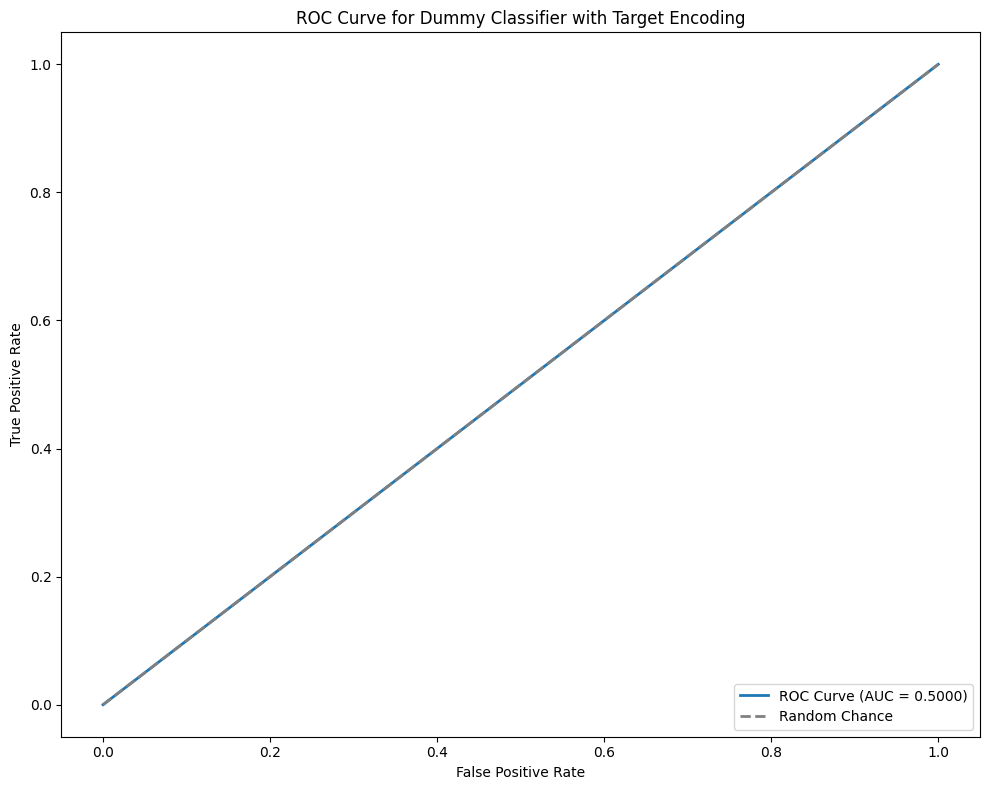

In [9]:
#Roc Curve

try:
    y_pred_proba = best_dummy_gs.predict_proba(X_test)[:, 1]
except Exception:
    y_pred_proba = np.array(y_pred_dummy_gs)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc_val = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, lw=2, label=f'ROC Curve (AUC = {roc_auc_val:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Dummy Classifier with Target Encoding')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


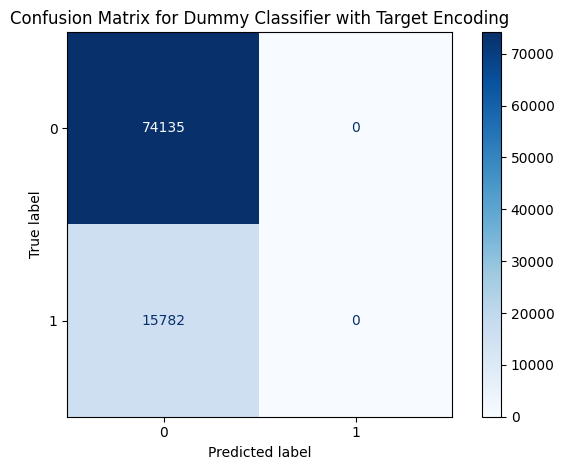

In [10]:

# Predict on the test set
y_pred = best_dummy_gs.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix for Dummy Classifier with Target Encoding")
plt.tight_layout()
plt.show()
